# Running EM on the birdsong corpus

## Getting set up

In [1]:
import markhov
import em
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Read in the birdsong corpus

In [2]:
f=open('../corpus/cath8.txt','r')
corpus = f.readlines()
f.close()
corpus = [line.rstrip('\n') for line in corpus]


Create a transition grammar for the corpus

In [3]:
trans = {'[':[]}
for s in corpus:
    s=['[']+s.split(' ')
    for i in range(1,len(s)):
        trans[s[i-1]]=trans.get(s[i-1],[])
        if s[i] not in trans[s[i-1]]:
            trans[s[i-1]].append(s[i])


Operations FSA

In [4]:
ops = {'S':{'NotCL':['mg']}, # from start we have to merge
       'NotCL':{'NotCL':['mg','copy'], # this state is the state in which the last "special" operation was *not* Clear. 
                #Either we've done none or the last was copy. From here we can do everything including end
               'CLEAR_S':['clear'], # go here to clear the buffer
               'F':['end'] # go here to end
           },
       'CLEAR_S':{'CLEAR':['mg']}, # this is where we've just cleared. Buffer is empty so you can only Merge
       'CLEAR':{'CLEAR':['mg'], # the last special op was Clear so we can Copy or Merge.
                'NotCL':['copy'] # if we Copy, the last special op was Copy so go to NotCL
            },
       'F':{} #final state
   }


## Expectation Maximisation time!

In [5]:
n = 10 # number of EM iterations to do

In [6]:
history=em.em_rabbit(corpus,trans,ops,n) # run EM

Display the results

In [7]:
import pandas as pd

Make the rules into a simpler list

In [8]:
rules=[]
for lhs in ops:
    for rhs in ops[lhs]:
        for e in ops[lhs][rhs]:
            rules.append(('%s->%s %s'%(lhs,e,rhs),(lhs,rhs,e)))

Put them and their updating probabilities into a table

In [9]:
tab=[]
for (rule,(lhs,rhs,e)) in rules:
    thisrule={'rule':rule}
    for i in range(n):
        p=history[i]['fsa'][lhs][rhs][e]
        thisrule["p.iteration%i"%i]=p
    tab.append(thisrule)

Use pandas to make the table into a datafram

In [10]:
df = pd.DataFrame(tab)

In [11]:
df

,p.iteration0,p.iteration1,p.iteration2,p.iteration3,p.iteration4,p.iteration5,p.iteration6,p.iteration7,p.iteration8,p.iteration9,rule
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,S->mg NotCL
1,-0.203488,-0.751940,-0.946793,-1.180579,-1.408352,-1.594409,-1.728080,-1.772726,-1.744751,-1.697900,CLEAR->mg CLEAR
2,-1.692166,-0.637620,-0.490995,-0.366871,-0.280436,-0.226936,-0.195559,-0.186172,-0.191994,-0.202199,CLEAR->copy NotCL
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,CLEAR_S->mg CLEAR
4,-3.753216,-2.360191,-3.004436,-3.760948,-4.418140,-4.970412,-5.467468,-5.969436,-6.539255,-7.163572,NotCL->clear CLEAR_S
5,-0.603877,-1.784095,-1.930394,-2.001754,-2.027406,-2.037838,-2.042965,-2.045823,-2.047569,-2.048592,NotCL->end F
6,-1.035034,-0.369515,-0.234339,-0.178867,-0.158075,-0.148967,-0.144287,-0.141604,-0.139927,-0.138946,NotCL->mg NotCL
7,-2.594872,-3.066601,-4.251078,-5.217109,-5.999049,-6.765872,-7.611350,-8.490563,-9.381040,-10.277650,NotCL->copy NotCL


In [12]:
df.to_csv('ops_%s.csv'%('oct_22_2016_aaa')) # print to file

Same for the transitions

In [13]:
bigrams=[]
for lhs in trans:
    for rhs in trans[lhs]:
        bigrams.append(('%s,%s'%(lhs,rhs),(lhs,rhs)))

In [14]:
tab=[]
for (bi,(lhs,rhs)) in bigrams:
    thisrule={'rule':bi}
    for i in range(n):
        p=history[i]['trans_probs'][lhs][rhs]
        thisrule["p.iteration%i"%i]=p
    tab.append(thisrule)

In [15]:
df_bis = pd.DataFrame(tab)

In [16]:
df_bis

,p.iteration0,p.iteration1,p.iteration2,p.iteration3,p.iteration4,p.iteration5,p.iteration6,p.iteration7,p.iteration8,p.iteration9,rule
0,-1.975227,-2.856652,-2.905019,-2.967763,-3.001191,-3.014381,-3.020347,-3.023562,-3.025553,-3.026870,"aua,aiz"
1,-3.706258,-0.908981,-0.869499,-0.903773,-0.927352,-0.937339,-0.942017,-0.944637,-0.946360,-0.947551,"aua,ats"
2,-2.259893,-1.055356,-1.068282,-0.988461,-0.944400,-0.927181,-0.919394,-0.915143,-0.912429,-0.910591,"aua,aua"
3,-2.213246,-3.262117,-3.310484,-3.373228,-3.406657,-3.419846,-3.425812,-3.429028,-3.431018,-3.432335,"aua,amb"
4,-2.260790,-3.955264,-4.003631,-4.066375,-4.099804,-4.112993,-4.118959,-4.122175,-4.124165,-4.125482,"aua,aje"
5,-2.034987,-3.262117,-3.310484,-3.373228,-3.406657,-3.419846,-3.425812,-3.429028,-3.431018,-3.432335,"aua,aiy"
6,-2.973861,-3.955264,-4.003631,-4.066375,-4.099804,-4.112993,-4.118959,-4.122175,-4.124165,-4.125482,"aua,aib"
7,-2.477670,-3.955264,-4.003631,-4.066375,-4.099804,-4.112993,-4.118959,-4.122175,-4.124165,-4.125482,"aua,ban"
8,-2.444026,-3.955264,-4.003631,-4.066375,-4.099804,-4.112993,-4.118959,-4.122175,-4.124165,-4.125482,"aua,awi"
9,-2.733341,-3.955264,-4.003631,-4.066375,-4.099804,-4.112993,-4.118959,-4.122175,-4.124165,-4.125482,"aua,abu"


In [17]:
df_bis.to_csv('trans_%s.csv'%('oct_22_2016_cath8'))

### Calculate the log likelihood of the corpus given the trained grammar

This is the ll of the corpus at the end of training:

In [18]:
# parse the corpus
parsed_corpus=em.parse_corpus(corpus,trans,ops)

In [19]:
markhov.ll_corpus(parsed_corpus,history[-1]['trans_probs'],history[-1]['fsa'])

-4388.4156568017579

Make a dataframe of the LL of the corpus throughout training:

In [20]:
tab=[]
for i in range(n):
    this_iter={'iteration':i,
               'likelihood':markhov.ll_corpus(parsed_corpus,history[i]['trans_probs'],history[i]['fsa'])}
    tab.append(this_iter)

In [21]:
df_lls=pd.DataFrame(tab)

In [22]:
df_lls

,iteration,likelihood
0,0,-7341.738456
1,1,-4664.395115
2,2,-4488.885655
3,3,-4429.958034
4,4,-4408.716195
5,5,-4399.348967
6,6,-4394.572468
7,7,-4391.636580
8,8,-4389.839828
9,9,-4388.901697


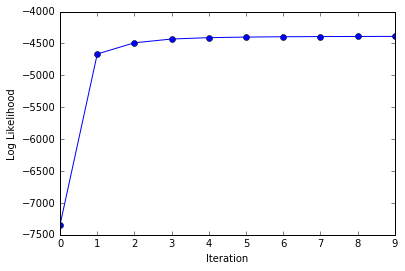

In [23]:
plot(df_lls["iteration"],df_lls["likelihood"],'o-')
xlabel("Iteration")
ylabel("Log Likelihood")

In [24]:
reload(em)

<module 'em' from 'em.pyc'>